In [1]:
!pip install transformers

#Importing libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel,MPNetForSequenceClassification,AutoModelForSequenceClassification
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer,XLMRobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

2022-12-03 01:47:06.611899: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Reading dataset

In [4]:
df=pd.read_csv('/kaggle/input/hasoc-hate-speech/H2_Hate_Offensive_Language_Identification_train.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7593 non-null   object
 1   label   7593 non-null   object
 2   id      7593 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 178.1+ KB


In [6]:
df['label'].unique()

array(['NOT', 'HOF'], dtype=object)

In [7]:
df

,text,label,id
0,"ऑटोरिक्शा चालक जावेद खान कहते हैं, ""कोविड-19 क...",NOT,0
1,@Raghuveerdutt62 @Arunesh24797107 रघुवीर जी यह...,NOT,1
2,@Drmahera552 @common000786 मोदी तुम इस्तीफा दो...,NOT,2
3,@sab_hateDMS Does she wear mesh hooker hose an...,HOF,3
4,What a bunch of absolute fucking idiots in #in...,HOF,4
...,...,...,...
7588,@NewsNationTV दीपक जी! आज के विपक्षी दल जनता क...,HOF,7588
7589,@pranaypiyush @ndtv That not gonna help india ...,NOT,7589
7590,@ABPNews इसमें विवादित क्या है ? ताड़का बेहतर ...,HOF,7590
7591,मक़तल में आ गया हूं तेरा साथ चाहता हूं तदफी़न ...,NOT,7591


In [8]:
df['label'] = df['label'].astype('category')
df['label'] = df['label'].cat.codes
df['label'] = df['label'].astype(np.int64)

In [9]:
df

,text,label,id
0,"ऑटोरिक्शा चालक जावेद खान कहते हैं, ""कोविड-19 क...",1,0
1,@Raghuveerdutt62 @Arunesh24797107 रघुवीर जी यह...,1,1
2,@Drmahera552 @common000786 मोदी तुम इस्तीफा दो...,1,2
3,@sab_hateDMS Does she wear mesh hooker hose an...,0,3
4,What a bunch of absolute fucking idiots in #in...,0,4
...,...,...,...
7588,@NewsNationTV दीपक जी! आज के विपक्षी दल जनता क...,0,7588
7589,@pranaypiyush @ndtv That not gonna help india ...,1,7589
7590,@ABPNews इसमें विवादित क्या है ? ताड़का बेहतर ...,0,7590
7591,मक़तल में आ गया हूं तेरा साथ चाहता हूं तदफी़न ...,1,7591


In [10]:
X = list(df['text'].values)
y = list(df['label'].values)

In [11]:
# X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = 0.10, random_state=42,stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.10, random_state=42,stratify=y)

# print(len(X_train))
# print(len(X_valid))
# print(len(X_test))

In [12]:
# import pickle
# filehandler = open("/content/drive/MyDrive/Project/y_valid.obj","wb")
# pickle.dump(y_valid,filehandler)
# filehandler.close()


In [13]:
# import pickle
# file = open("/content/drive/MyDrive/Project/X_train.obj","rb")
# X_train = pickle.load(file)
# file.close()
# file = open("/content/drive/MyDrive/Project/X_valid.obj","rb")
# X_valid = pickle.load(file)
# file.close()
# file = open("/content/drive/MyDrive/Project/y_train.obj","rb")
# y_train = pickle.load(file)
# file.close()
# file = open("/content/drive/MyDrive/Project/y_valid.obj","rb")
# y_valid = pickle.load(file)
# file.close()

##Pre-processing the whole dataset

In [14]:
df['text'] = df.text.astype(str)

# Load Model

In [15]:
# model_name = 'distilbert-base-uncased'
model_name='l3cube-pune/hing-roberta'
# model_name='microsoft/mpnet-base'
# model_name='sentence-transformers/all-mpnet-base-v2'
def generate_dataset(X,y, tokenizer):

  #Generate encodings
  encodings = tokenizer.batch_encode_plus(X,        
                                          truncation = True,
                                          padding=True,
                                          max_length=128,
                                          return_tensors='pt',
                                          add_special_tokens = True)

  #convert to tensor dataset
  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']

  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)
  y = torch.tensor(y)

  dataset = TensorDataset(input_ids,attention_mask,y)

  return dataset

In [16]:
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
tokenizer=AutoTokenizer.from_pretrained(model_name)
# tokenizer=XLMRobertaTokenizer.from_pretrained(model_name)
train_dataset = generate_dataset(X_train,y_train,tokenizer)
valid_dataset = generate_dataset(X_valid,y_valid,tokenizer)

Downloading:   0%|          | 0.00/750 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

In [17]:
def get_data_loader(dataset,sampler):
  return DataLoader(dataset=dataset,sampler=sampler(dataset),batch_size=16)

In [18]:
train_loader = get_data_loader(train_dataset,RandomSampler)
validation_loader = get_data_loader(valid_dataset,SequentialSampler)

### Load Sequence Classifier

In [19]:
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model=XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model= MPNetForSequenceClassification.from_pretrained(model_name,num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
# path='/content/drive/MyDrive/Project/final_english_model_hing-roberta_16_2e6.pt'
# model = torch.load(path)
# model = model.to(device)

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of the model checkpoint at l3cube-pune/hing-roberta were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-roberta and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'clas

In [20]:
model.cuda()
print("Imported model!")

Imported model!


In [21]:
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

num_epochs = 5
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Training Pipeline

In [22]:
def train():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  num_steps = 0

  for step,batch in enumerate(train_loader):
    
    
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}'.format(step, len(train_loader)))


    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()
    # with warmup_scheduler.dampening():
    #   lr_scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc


## Evaluation Pipeline

In [23]:
def evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):
    
    
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)
    if step % 50 == 0 and not step == 0:
      
      val=classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']
      print('  Batch {:>5,}  of  {:>5,}. with val score {}'.format(step, len(validation_loader), val))
      # print(f'Val f1 score{val}')
  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [24]:
# path='final_english_model_hing-roberta_20_2e5.pt'
# model = torch.load(path)
# model = model.to(device)

# Training Loop
### save best model

In [25]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = 1.0

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
  
  train_loss, train_acc = train()
  valid_loss, valid_acc,f1_score = evaluate()

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)

  if valid_loss<best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model,'final_english_model_hing-roberta_21_2e5.pt')

  print("Best Validation Loss :",best_valid_loss)
  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:3f}')


 Epoch 1 / 5
  Batch    50  of    428
  Batch   100  of    428
  Batch   150  of    428
  Batch   200  of    428
  Batch   250  of    428
  Batch   300  of    428
  Batch   350  of    428
  Batch   400  of    428
Best Validation Loss : 0.4879544007902344

Training Accuracy: 0.763 | Training Loss: 0.517 | Validation Accuracy: 0.767 | Validation Loss: 0.488 | F1 Score: 0.760590

 Epoch 2 / 5
  Batch    50  of    428
  Batch   100  of    428
  Batch   150  of    428
  Batch   200  of    428
  Batch   250  of    428
  Batch   300  of    428
  Batch   350  of    428
  Batch   400  of    428
Best Validation Loss : 0.43549821929385263

Training Accuracy: 0.823 | Training Loss: 0.408 | Validation Accuracy: 0.802 | Validation Loss: 0.435 | F1 Score: 0.800417

 Epoch 3 / 5
  Batch    50  of    428
  Batch   100  of    428
  Batch   150  of    428
  Batch   200  of    428
  Batch   250  of    428
  Batch   300  of    428
  Batch   350  of    428
  Batch   400  of    428
Best Validation Loss : 0.

#Eval on Test

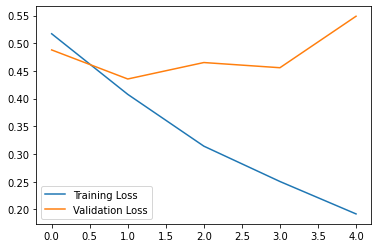

In [35]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["Training Loss","Validation Loss"])
plt.show()

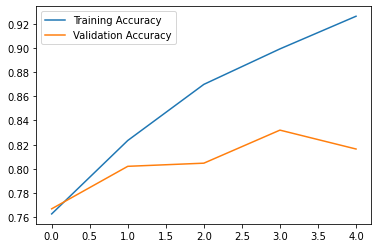

In [36]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

### Load Best Model

In [26]:
# test_dataset = generate_dataset(X_test,y_test,tokenizer)
# test_loader = get_data_loader(test_dataset,SequentialSampler)
test_loader=validation_loader
path='final_english_model_hing-roberta_20_2e5.pt'
model = torch.load(path)
model = model.to(device)

RuntimeError: [enforce fail at inline_container.cc:145] . PytorchStreamReader failed reading zip archive: failed finding central directory

### Confirm Best Model performance with validation set

In [ ]:
def test_evaluate(model):
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(test_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(test_loader)
  avg_acc = total_acc/len(test_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [ ]:
test_loss,test_acc,f1_score = test_evaluate(model)
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f} ')

## Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
len(y_pred)

#Actual test

In [ ]:
df_test_set=pd.read_csv('/kaggle/input/hasoc-hate-speech/H2_Hate_Offensive_Language_Identification_test.csv')

In [ ]:
df_test_set['labels']=list(np.ones(df_test_set['text'].values.shape[0]))

In [ ]:
X_test_set = list(df_test_set['text'].values)
y_test_set = list(df_test_set['labels'].values)

In [ ]:
df_test_set.info()

In [ ]:
test_dataset = generate_dataset(X_test_set,y_test_set,tokenizer)
# test_loader = get_data_loader(test_dataset,SequentialSampler)
test_loader=DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)
# path='/content/drive/MyDrive/NLP /Project/final_english_model_robert_8Sept.pt'
# path='/content/drive/MyDrive/NLP /Project/final_english_model_roberta16.pt'
# path='/content/drive/MyDrive/Project/final_english_model_distill_20_lr_0.5e6.pt'
# path='/content/drive/MyDrive/Project/final_english_model_hing-roberta_16_2e5.pt'
# path='/content/drive/MyDrive/Project/final_english_model_hing-roberta_16_2e6.pt'
path='final_english_model_hing-roberta_21_2e5.pt'
model = torch.load(path)
model = model.to(device)

 # Generate Predictions File

In [ ]:
def generate_predictions(model,test_loader):
  model.train()
    
  true_labels = []
  predictions = []
  ids=[]
  for step,batch in enumerate(test_loader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    # import pdb; pdb.set_trace()
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    predictions.extend(logits)
    # ids.extend(input_ids.detach().cpu().numpy())
  df =pd.DataFrame()
  df['label']=predictions
  # df['id']=ids
  return df

In [ ]:
predicted_df=generate_predictions(model,test_loader)

In [ ]:
predicted_df['id']=list(df_test_set['id'].values)

In [ ]:
y_pred=predicted_df['label']

In [ ]:
predicted_df.to_csv('H2_predictions_hing-roberta_21_2e5.csv',index=False)